## Import Packages

In [6]:
import pandas as pd
import numpy as np
import statsmodels
from statsmodels.tsa.stattools import coint

import yfinance as yf

import matplotlib.pyplot as plt

from backtesting import Backtest, Strategy
from backtesting.lib import crossover
from backtesting.test import SMA #,GOOG

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

/opt/anaconda3/lib/python3.12/site-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

/opt/anaconda3/lib/python3.12/site-packages/backtesting/test/__init__.py:8: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.read_csv(join(dirname(__file__), filename),
/opt/anaconda3/lib/python3.12/site-packages/backtesting/test/__init__.py:8: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.read_csv(join(dirname(__file__), filename),


In [2]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install backtesting

Note: you may need to restart the kernel to use updated packages.


## Import equity data from yfinance

In [8]:
aapl = yf.Ticker("AAPL")
AAPL = aapl.history(start="2016-06-02", end="2023-06-07")

AAPL

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2016-06-02 00:00:00-04:00,22.385162,22.440207,22.162686,22.412685,160766400,0.0,0.0
2016-06-03 00:00:00-04:00,22.428740,22.538830,22.350758,22.458555,114019600,0.0,0.0
2016-06-06 00:00:00-04:00,22.474607,23.369097,22.373692,22.621395,93170000,0.0,0.0
2016-06-07 00:00:00-04:00,22.763599,22.905801,22.697086,22.713140,89638000,0.0,0.0
2016-06-08 00:00:00-04:00,22.710850,22.834703,22.632870,22.692503,83392400,0.0,0.0
...,...,...,...,...,...,...,...
2023-05-31 00:00:00-04:00,176.189289,178.196300,175.622949,176.109802,99625300,0.0,0.0
2023-06-01 00:00:00-04:00,176.556893,178.961324,175.791842,178.931519,68901800,0.0,0.0
2023-06-02 00:00:00-04:00,179.865467,180.610643,178.106849,179.785980,61945900,0.0,0.0


In [41]:
aapl_data = yf.download('AAPL', '2016-06-02', '2023-06-07')

[*********************100%***********************]  1 of 1 completed


In [43]:
aapl_data['SMA_50'] = aapl_data['Close'].rolling(window=50).mean()
aapl_data['SMA_200'] = aapl_data['Close'].rolling(window=200).mean()

In [45]:
aapl_data['Signal'] = 0  # 0 indicates no signal
aapl_data.loc[aapl_data['SMA_50'] > aapl_data['SMA_200'], 'Signal'] = 1  # 1 indicates buy signal
aapl_data.loc[aapl_data['SMA_50'] < aapl_data['SMA_200'], 'Signal'] = -1  # -1 indicates sell signal

In [47]:
aapl_data['Daily_Return'] = aapl_data['Close'].pct_change()
aapl_data['Strategy_Return'] = aapl_data['Signal'].shift(1) * aapl_data['Daily_Return']

In [49]:
aapl_data['Cumulative_Strategy_Return'] = (1 + aapl_data['Strategy_Return']).cumprod()

In [65]:
print("Cumulative Strategy Return:")
print(aapl_data['Cumulative_Strategy_Return'].iloc[-1])

Cumulative Strategy Return:
1.924380629879949


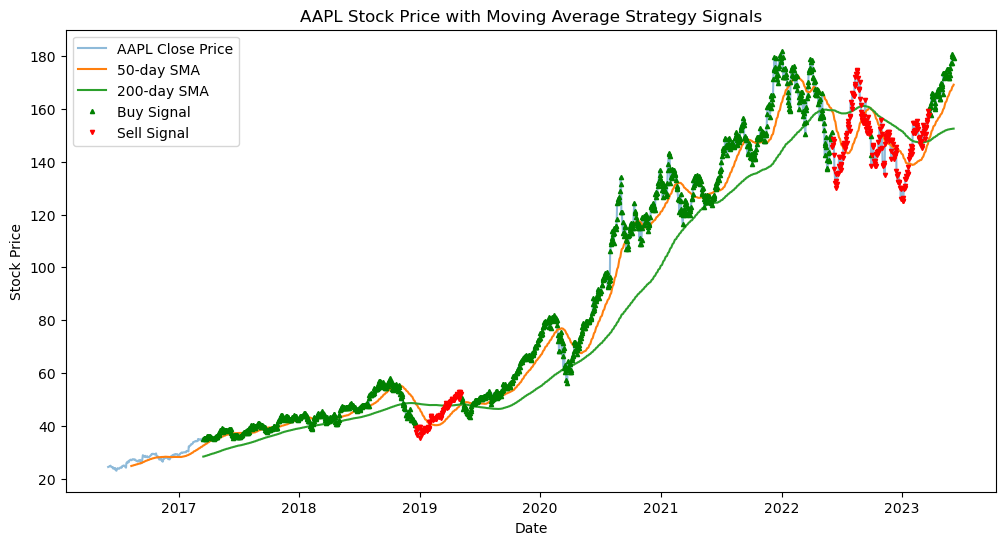

In [53]:
plt.figure(figsize=(12, 6))
plt.plot(aapl_data['Close'], label='AAPL Close Price', alpha=0.5)
plt.plot(aapl_data['SMA_50'], label='50-day SMA')
plt.plot(aapl_data['SMA_200'], label='200-day SMA')
plt.plot(aapl_data.loc[aapl_data['Signal'] == 1, 'Close'], '^', markersize=3, color='g', label='Buy Signal')
plt.plot(aapl_data.loc[aapl_data['Signal'] == -1, 'Close'], 'v', markersize=3, color='r', label='Sell Signal')
plt.title('AAPL Stock Price with Moving Average Strategy Signals')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [55]:
mean_strategy_return = aapl_data['Strategy_Return'].mean()
std_dev_strategy_return = aapl_data['Strategy_Return'].std(ddof=1)

# ddof=1 or Delta Degrees of Freedom for sample standard deviation

# Annual risk-free rate
annual_risk_free_rate = 0.05

# Convert annual risk-free rate to daily rate
daily_risk_free_rate = annual_risk_free_rate / 252

# Calculate Sharpe Ratio with daily risk-free rate
excess_return = aapl_data['Strategy_Return'] - daily_risk_free_rate
sharpe_ratio = np.sqrt(len(aapl_data)) * (mean_strategy_return / std_dev_strategy_return)

print(f"Sharpe Ratio with daily risk-free rate: {sharpe_ratio}")

Sharpe Ratio with daily risk-free rate: 1.2298139158376986


## Create and backtest strategy (using backtesting library)

In [2]:
class SmaCross(Strategy):
    n1 = 10 #sma params
    n2 = 20

    def init(self):
        close = self.data.Close
        self.sma1 = self.I(SMA, close, self.n1)
        self.sma2 = self.I(SMA, close, self.n2)

    def next(self):
        if crossover(self.sma1, self.sma2):
            self.buy()
        elif crossover(self.sma2, self.sma1):
            self.sell()



bt = Backtest(AAPL, SmaCross,
              cash=10000, commission=.002,
              exclusive_orders=True)

output = bt.run()
bt.plot(plot_volume=False)
output

NameError: name 'Strategy' is not defined

## Optimize strategy parameters

In [59]:
stats = bt.optimize(n1=range(5, 30, 5),
                    n2=range(10, 70, 5),
                    maximize='Equity Final [$]',
                    constraint=lambda param: param.n1 < param.n2)
stats

  0%|          | 0/9 [00:00<?, ?it/s]

Start                     2016-06-02 00:00...
End                       2023-06-06 00:00...
Duration                   2560 days 00:00:00
Exposure Time [%]                   98.640227
Equity Final [$]                 68864.176992
Equity Peak [$]                  69239.045556
Return [%]                          588.64177
Buy & Hold Return [%]              694.448129
Return (Ann.) [%]                   31.718116
Volatility (Ann.) [%]               37.725041
Sharpe Ratio                         0.840771
Sortino Ratio                         1.70419
Calmar Ratio                         1.119742
Max. Drawdown [%]                  -28.326284
Avg. Drawdown [%]                   -4.344844
Max. Drawdown Duration      456 days 00:00:00
Avg. Drawdown Duration       28 days 00:00:00
# Trades                                   97
Win Rate [%]                        44.329897
Best Trade [%]                      52.172197
Worst Trade [%]                    -15.693976
Avg. Trade [%]                    

In [61]:
stats._strategy

<Strategy SmaCross(n1=5,n2=15)>

In [15]:
#stats['_trades'] #show all trades

[*********************100%***********************]  2 of 2 completed


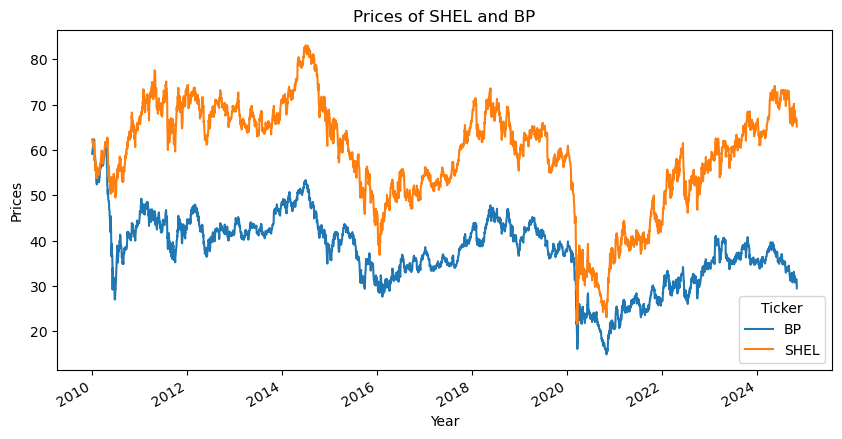

P-value: 0.030661299778588513


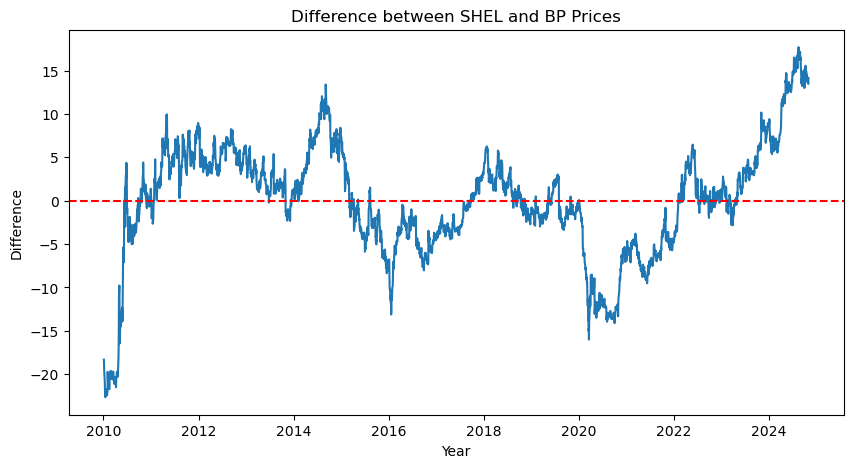

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
#from statsmodels.tsa.stattools import adfuller


pairs = ['SHEL', 'BP']
data = yf.download(pairs, '2010-01-01')['Close']
data.index = pd.to_datetime(data.index)


data.plot(figsize=(10, 5))
plt.title('Prices of SHEL and BP')
plt.ylabel('Prices')
plt.xlabel('Year')
plt.show()


SHEL = data['SHEL']
BP = data['BP']


coint_t, p_value, critical_values = coint(SHEL, BP)

# Output the results
print(f"P-value: {p_value}")

# Calculate the difference
diff = SHEL - BP
mean_diff = diff.mean()
normed_diff = diff-mean_diff

# Plot the difference
plt.figure(figsize=(10, 5))
plt.plot(normed_diff)
plt.title('Difference between SHEL and BP Prices')
plt.ylabel('Difference')
plt.xlabel('Year')
plt.axhline(0, color='red', linestyle='--')  # Add a horizontal line at 0
plt.show()
